In [3]:
from ete3 import Tree
from Bio import Phylo
from io import StringIO
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import numpy as np
import seaborn as sns

In [5]:
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm

In [6]:

def branching_factor(tree):
    bf = []
    for i in tree.get_nonterminals():
        bf.append(len(i.clades))
    bf = np.array(bf)
    return bf[bf>1]

In [7]:
def allel_edit_distance(al1, al2):
    n = len(al1)
    diff, cnt = 0, 0
    for i in range(n):
        if (al1[i] == '_') or (al2[i] == '_'):
            continue
        cnt += 1
        if al1[i] != al2[i]:
            if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
                diff += 1
            else:
                diff += 2
    return diff / cnt           

def phylogenetic_distance(tree, node1, node2):
    return tree.distance(node1, node2)

In [8]:
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'

In [9]:
crispr_tree_chan = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'
for i in [1,2,3,6]:
    with open(data_path+f'trees/embryo{i}_all.newick', 'r') as f:
        tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    crispr_tree_chan['terminal'].append(len(tree.get_terminals()))
    crispr_tree_chan['nonterminal'].append(len(tree.get_nonterminals()))
    crispr_tree_chan['branching_factor'].append(branching_factor(tree).mean())
    p_dist, ae_dist = [], []
    em = i
    if em == 2:
        alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}a_alleleTable.txt', sep='\t', index_col=0)
        alleletab1 = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}b_alleleTable.txt', sep='\t', index_col=0)
    else:
        if em >= 3:
            alleletab = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0)
        else:                                          
            alleletab = pd.read_csv(data_path + f'GSM{3302825+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0)

    for _ in tqdm(range(1000)):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        try:
            al1 = alleletab.loc[f'{c1.name}-1']
        except:
            al1 = alleletab1.loc[f'{c1.name}-1']
        try:
            al2 = alleletab.loc[f'{c2.name}-1']
        except:
            al2 = alleletab1.loc[f'{c2.name}-1']
            
        
        if len(al1.shape) == 1:
            al1 = pd.DataFrame(al1).T
        if len(al2.shape) == 1:
            al2 = pd.DataFrame(al2).T
        intbc = set(al1['intBC']).intersection(set(al2['intBC']))
        all1 = ''
        all2 = ''
        for ibc in intbc:
            all1 += str(al1[al1['intBC']==ibc]['allele1'])
            all2 += str(al2[al2['intBC']==ibc]['allele1']) 
        ae_dist.append(allel_edit_distance(all1.split('_'), all2.split('_')))
    crispr_tree_chan['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    crispr_tree_chan['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s]


In [10]:
crispr_tree_yang = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/data3/wangkun/phylovelo_datasets/KPTracer-Data/trees/'
trees = os.listdir(data_path)
trees = [i for i in trees if (i[-5:]=='e.nwk')]

for i in tqdm(trees):
    with open(data_path+i, 'r') as f:
        tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    n_nt = 0
    for j in tree.get_nonterminals():
        if len(j.clades) > 1:
            n_nt += 1
    crispr_tree_yang['terminal'].append(len(tree.get_terminals()))
    crispr_tree_yang['nonterminal'].append(n_nt)
    crispr_tree_yang['branching_factor'].append(branching_factor(tree).mean())
    charater_mat = pd.read_csv(data_path+i.replace('_tree.nwk', '_character_matrix.txt'), sep='\t', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(charater_mat.loc[c1.name], charater_mat.loc[c2.name]))
    crispr_tree_yang['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    crispr_tree_yang['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

  0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
  1%|     

 11%|█         | 9/85 [00:42<08:04,  6.38s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 1

 21%|██        | 18/85 [01:08<03:36,  3.23s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 32%|███▏      | 27/85 [01:29<02:02,  2.11s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 42%|████▏     | 36/85 [01:48<01:32,  1.88s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 53%|█████▎    | 45/85 [02:38<06:24,  9.62s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 64%|██████▎   | 54/85 [03:21<03:20,  6.45s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 74%|███████▍  | 63/85 [04:00<01:17,  3.50s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 85%|████████▍ | 72/85 [05:16<04:12, 19.45s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

 95%|█████████▌| 81/85 [06:49<00:29,  7.27s/it]/tmp/ipykernel_332772/1832192097.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == '_') or (al2[i] == '_'):
/tmp/ipykernel_332772/1832192097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if al1[i] != al2[i]:
/tmp/ipykernel_332772/1832192097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (al1[i] == 0) or (al2[i] == 0) or (al1[i] == '0') or (al2[i] == '0'):
 

In [11]:
smtree = pd.read_csv('/syn2/zhaolian/1.SMALT/2.Result/1.SMALT_manu_new/figures/3.1.CRC_Apc_stats.txt', sep='\t')

In [11]:
smalt_tree = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
# smalt_tree_poly = {'terminal':[], 'nonterminal':[], 'branching_factor':[]}
data_path = '/syn2/zhaolian/1.SMALT/2.Result/1.SMALT_manu_new/2.final_phy_re/'
# trees = os.listdir(data_path)
# trees = [i for i in trees if (i[-5:]=='e.nwk') and ('T' in i.split('_')[1])]
for i in tqdm(smtree['sample']):
    with open(data_path+f'{i}_filtered_re_rescale.nwk', 'r') as f:
        tree_nwk = f.readline()
    cls = tree_nwk.split(':0.00000)')
    for j, cl in enumerate(cls[:-1]):
        success = 0
        jj = j
        while not success:
            try:
                k = -cls[jj][::-1].index('(')
                new = cls[jj][:k-1] + cls[jj][k:]
                assert ')' not in cls[jj][k:]
                cls[jj] = new
                success = 1
            except:
                jj -= 1
        assert success == 1
    t = Tree(''.join(cls))
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    smalt_tree['terminal'].append(len(tree.get_terminals()))
    smalt_tree['nonterminal'].append(len(tree.get_nonterminals()))
    smalt_tree['branching_factor'].append(branching_factor(tree).mean())
    alltab = pd.read_csv(data_path+f'{i}_filtered_re.phy', sep=' ', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(alltab.loc[c1.name].iloc[0], alltab.loc[c2.name].iloc[0]))
    smalt_tree['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    smalt_tree['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])
    # if '_'.join(i.split('_')[:2]) in mono:
    #     smalt_tree_mono['terminal'].append(len(tree.get_terminals()))
    #     smalt_tree_mono['nonterminal'].append(len(tree.get_nonterminals()))
    #     smalt_tree_mono['branching_factor'].append(branching_factor(tree).mean())
    # else:
    #     smalt_tree_poly['terminal'].append(len(tree.get_terminals()))
    #     smalt_tree_poly['nonterminal'].append(len(tree.get_nonterminals()))
    #     smalt_tree_poly['branching_factor'].append(branching_factor(tree).mean())
    


100%|██████████| 77/77 [12:28<00:00,  9.73s/it]


In [12]:
pd.DataFrame(smalt_tree)

,terminal,nonterminal,branching_factor,pearsonr,spearmanr
0,776,648,2.195988,0.891750,0.866227
1,661,620,2.064516,0.798389,0.726280
2,2285,2043,2.117964,0.956498,0.873041
3,1228,1073,2.143523,0.970946,0.907781
4,1043,912,2.142544,0.888880,0.766654
...,...,...,...,...,...
72,464,447,2.035794,0.912736,0.848938
73,1267,1137,2.113456,0.965332,0.933641
74,1314,1207,2.087821,0.833937,0.735976
75,3650,3445,2.059216,0.895897,0.817026


/tmp/ipykernel_137573/4046015861.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'SMALT tree'])


[Text(0, 0, 'Crispr tree\n(Chan 2019)'),
 Text(1, 0, 'Crispr tree\n(Yang 2022)'),
 Text(2, 0, 'SMALT tree')]

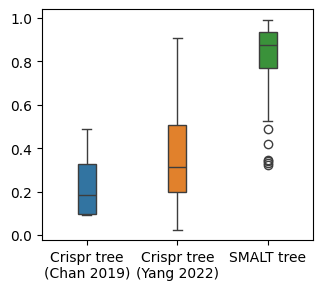

In [13]:
fig, ax = plt.subplots(figsize=(3.5,3))
sns.boxplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(smalt_tree['nonterminal'])/np.array(smalt_tree['terminal']),
            ], width=0.2, ax=ax)
ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'SMALT tree'])

In [39]:
smtree = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/branch_index.list', sep='\t')
smtree

,sample
0,C1
1,C100-46
2,C102-51
3,C103-49
4,C105-82
...,...
98,C96-16
99,C97-97
100,C98-101
101,C9-866


In [6]:
eTRACER_tree = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/'
for i in tqdm(smtree['sample']):
    if i == 'C1':
        with open(data_path+'C1_downsampling5k/C1_downsampling5k.phy.treefile', 'r') as f:
            tree_nwk = f.readline()        
    else:
        with open(data_path+'cell_mutation_matrix-'+f'{i}.phy.treefile', 'r') as f:
            tree_nwk = f.readline()
    t = Tree(tree_nwk)
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    eTRACER_tree['terminal'].append(len(tree.get_terminals()))
    eTRACER_tree['nonterminal'].append(len(tree.get_nonterminals()))
    eTRACER_tree['branching_factor'].append(branching_factor(tree).mean())
    if i == 'C1':
        alltab = pd.read_csv(data_path+'C1_downsampling5k/C1_downsampling5k.phy', sep='\t', index_col=0)
    else:
        alltab = pd.read_csv(data_path+'cell_mutation_matrix-'+f'{i}.phy', sep='\t', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(alltab.loc[c1.name].iloc[0], alltab.loc[c2.name].iloc[0]))
    eTRACER_tree['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    eTRACER_tree['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

NameError: name 'smtree' is not defined

In [41]:
pd.DataFrame(eTRACER_tree)

,terminal,nonterminal,branching_factor,pearsonr,spearmanr
0,5000,2879,2.736367,0.749731,0.645246
1,46,29,2.551724,0.755081,0.725772
2,51,32,2.562500,0.744924,0.741183
3,49,40,2.200000,0.514118,0.628978
4,82,47,2.723404,0.839310,0.815727
...,...,...,...,...,...
98,16,11,2.363636,-0.057335,0.275095
99,97,70,2.371429,0.828878,0.817422
100,101,62,2.612903,0.812154,0.811470
101,866,493,2.754564,0.858558,0.856520


/tmp/ipykernel_137573/366996786.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'eTRACER tree'])


Text(0, 0.5, 'Branching index')

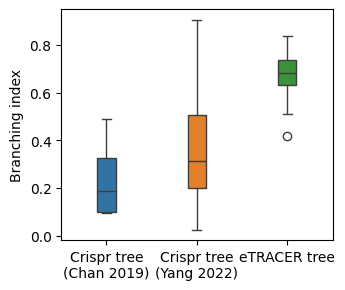

In [42]:
fig, ax = plt.subplots(figsize=(3.5,3))
sns.boxplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(eTRACER_tree['nonterminal'])/np.array(eTRACER_tree['terminal']),
            ], width=0.2, ax=ax)
ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'eTRACER tree'])
plt.ylabel('Branching index')

In [12]:
eTRACERtree = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/branch_index.list', sep='\t')
eTRACER_tree = {'terminal':[], 'nonterminal':[], 'branching_factor':[], 'pearsonr':[], 'spearmanr':[]}
data_path = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/merge_all_experiments/T2_and_T3/polytomy/'
for i in tqdm(eTRACERtree['sample']):
    if i == 'C1':
        with open(data_path+'C1_downsampling5k/C1_downsampling5k.phy.treefile', 'r') as f:
            tree_nwk = f.readline()        
    else:
        with open(data_path+'cell_mutation_matrix-'+f'{i}.phy.treefile', 'r') as f:
            tree_nwk = f.readline()
    cls = tree_nwk.split(':0.00000)')
    for j, cl in enumerate(cls[:-1]):
        success = 0
        jj = j
        while not success:
            try:
                k = -cls[jj][::-1].index('(')
                new = cls[jj][:k-1] + cls[jj][k:]
                assert ')' not in cls[jj][k:]
                cls[jj] = new
                success = 1
            except:
                jj -= 1
        assert success == 1
    t = Tree(''.join(cls))
    f = StringIO(t.write())
    tree = Phylo.read(f, 'newick')
    f.close()
    eTRACER_tree['terminal'].append(len(tree.get_terminals()))
    eTRACER_tree['nonterminal'].append(len(tree.get_nonterminals()))
    eTRACER_tree['branching_factor'].append(branching_factor(tree).mean())
    if i == 'C1':
        alltab = pd.read_csv(data_path+'C1_downsampling5k/C1_downsampling5k.phy', sep='\t', index_col=0)
    else:
        alltab = pd.read_csv(data_path+'cell_mutation_matrix-'+f'{i}.phy', sep='\t', index_col=0)
    p_dist, ae_dist = [], []
    for _ in range(1000):
        terminals = tree.get_terminals()
        c1, c2 = np.random.choice(range(len(terminals)), 2, replace=False)
        c1, c2 = terminals[c1], terminals[c2]
        p_dist.append(phylogenetic_distance(tree, c1, c2))
        ae_dist.append(allel_edit_distance(alltab.loc[c1.name].iloc[0], alltab.loc[c2.name].iloc[0]))
    eTRACER_tree['pearsonr'].append(pearsonr(p_dist, ae_dist)[0])
    eTRACER_tree['spearmanr'].append(spearmanr(p_dist, ae_dist)[0])

100%|██████████| 103/103 [02:41<00:00,  1.57s/it]


/tmp/ipykernel_273831/95720799.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'eTRACER tree'])


<Figure size 400x400 with 0 Axes>

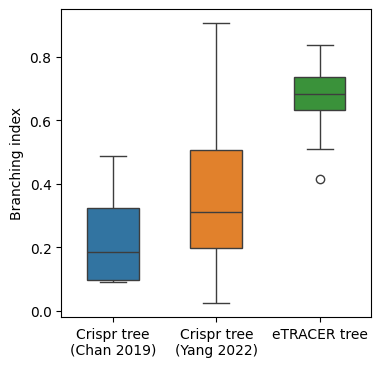

In [13]:
plt.rcParams['pdf.fonttype'] = 42
plt.gcf().set_size_inches(4, 4)
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(eTRACER_tree['nonterminal'])/np.array(eTRACER_tree['terminal']),
            ], boxprops=dict(facecolor='none', edgecolor='black'),width=0.5, ax=ax)
sns.stripplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(eTRACER_tree['nonterminal'])/np.array(eTRACER_tree['terminal']),
            ],
    color='darkblue', size=4, jitter=True, alpha=0.7
)
ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'eTRACER tree'])
plt.ylabel('Branching index')
plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure2/branch_index.pdf')

/tmp/ipykernel_237884/1595588890.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'eTRACER tree'])


Text(0, 0.5, 'Branching index')

<Figure size 400x400 with 0 Axes>

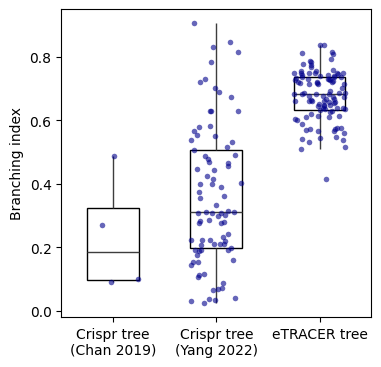

In [15]:
plt.rcParams['pdf.fonttype'] = 42
plt.gcf().set_size_inches(4, 4)
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(eTRACER_tree['nonterminal'])/np.array(eTRACER_tree['terminal']),
            ], boxprops=dict(facecolor='none', edgecolor='black'),width=0.5,fliersize=0,
            capprops=dict(visible=False) , ax=ax)
sns.stripplot([np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']), 
             np.array(crispr_tree_yang['nonterminal'])/np.array(crispr_tree_yang['terminal']),
             np.array(eTRACER_tree['nonterminal'])/np.array(eTRACER_tree['terminal']),
            ],
    color='darkblue', size=4, jitter=0.25, alpha=0.6
)
ax.set_xticklabels(['Crispr tree\n(Chan 2019)', 'Crispr tree\n(Yang 2022)', 'eTRACER tree'])
plt.ylabel('Branching index')
#plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure2/branch_index.pdf')

/tmp/ipykernel_237884/960162261.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Group", y="Branching index", ax=ax,
/tmp/ipykernel_237884/960162261.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="Group", y="Branching index", ax=ax,
/tmp/ipykernel_237884/960162261.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')


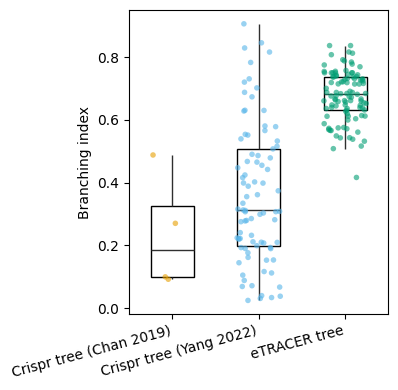

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 整理数据
data = {
    "Crispr tree (Chan 2019)": np.array(crispr_tree_chan['nonterminal']) / np.array(crispr_tree_chan['terminal']),
    "Crispr tree (Yang 2022)": np.array(crispr_tree_yang['nonterminal']) / np.array(crispr_tree_yang['terminal']),
    "eTRACER tree": np.array(eTRACER_tree['nonterminal']) / np.array(eTRACER_tree['terminal'])
}

df = pd.DataFrame([(key, val) for key, values in data.items() for val in values], columns=["Group", "Branching index"])

# 自定义配色（你可以换成喜欢的颜色）
palette = {
    "Crispr tree (Chan 2019)": "#E69F00",   # 橘色
    "Crispr tree (Yang 2022)": "#56B4E9",   # 蓝色
    "eTRACER tree": "#009E73"              # 绿色
}

# 画图
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(data=df, x="Group", y="Branching index", ax=ax,
            boxprops=dict(facecolor='none', edgecolor='black'),
            width=0.5, fliersize=0, capprops=dict(visible=False),
            palette=palette)

sns.stripplot(data=df, x="Group", y="Branching index", ax=ax,
              size=4, jitter=0.25, alpha=0.6,
              palette=palette)

ax.set_ylabel("Branching index")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

# plt.savefig("branch_index.pdf")
plt.tight_layout()
plt.show()


/tmp/ipykernel_332772/4002482158.py:40: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x="Group", y="Branching index", ax=ax,
/home/liangzhen/anaconda3/envs/cellrank2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/liangzhen/anaconda3/envs/cellrank2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Crispr tree (Chan 2019) vs. Crispr tree (Yang 2022): Mann-Whitney-Wilcoxon test two-sided, P_val:2.548e-01 U_stat=1.120e+02
Crispr tree (Yang 2022) vs. eTRACER tree: Mann-Whitney-Wilcoxon test two-sided, P_val:3.555e-20 U_stat=9.605e+02
Crispr tree (Chan 2019) vs. eTRACER tree: Mann-Whitney-Wilcoxon test two-sided, P_val:7.830e-04 U_stat=1.000e+00


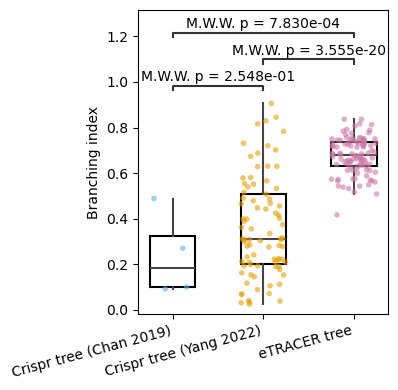

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import ttest_ind

# 整理数据
data = {
    "Crispr tree (Chan 2019)": np.array(crispr_tree_chan['nonterminal']) / np.array(crispr_tree_chan['terminal']),
    "Crispr tree (Yang 2022)": np.array(crispr_tree_yang['nonterminal']) / np.array(crispr_tree_yang['terminal']),
    "eTRACER tree": np.array(eTRACER_tree['nonterminal']) / np.array(eTRACER_tree['terminal'])
}

df = pd.DataFrame([(key, val) for key, values in data.items() for val in values], columns=["Group", "Branching index"])

# 自定义配色
palette = {
    "Crispr tree (Chan 2019)": "#56B4E9",
    "Crispr tree (Yang 2022)": "#E69F00",
    "eTRACER tree": "#CC79A7"
}

# 组间比较设置
pairs = [
    ("Crispr tree (Chan 2019)", "Crispr tree (Yang 2022)"),
    ("Crispr tree (Chan 2019)", "eTRACER tree"),
    ("Crispr tree (Yang 2022)", "eTRACER tree")
]

# 画图
plt.rcParams['pdf.fonttype'] = 42
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(data=df, x="Group", y="Branching index", ax=ax,
            boxprops=dict(facecolor='none', edgecolor='black'),
            width=0.5, fliersize=0, capprops=dict(visible=False),
            palette=palette)

sns.stripplot(data=df, x="Group", y="Branching index", ax=ax,
              size=4, jitter=0.25, alpha=0.6,
              palette=palette)

# 添加显著性
annotator = Annotator(ax, pairs, data=df, x="Group", y="Branching index")
annotator.configure(test="Mann-Whitney", text_format="full", loc="inside", comparisons_correction=None)
annotator.apply_and_annotate()

ax.set_ylabel("Branching index")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure2/branch_index.pdf')
plt.show()


In [18]:
len(np.array(crispr_tree_chan['nonterminal'])/np.array(crispr_tree_chan['terminal']))

4

In [19]:
len(np.array(crispr_tree_yang['nonterminal']) / np.array(crispr_tree_yang['terminal']))

85

In [21]:
len(np.array(eTRACER_tree['nonterminal']) / np.array(eTRACER_tree['terminal']))

103